In [1]:
#Libraries

# Data Manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import category_encoders as ce

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# !pip install category_encoders

In [3]:
# Load dataset
raw_train = pd.read_csv('train.csv')
raw_test = pd.read_csv('test.csv')
raw_combined = [raw_train, raw_test]
print('train', raw_train.shape)
print('test', raw_test.shape)

pd.set_option('display.max_columns', None)

# Test data doesn't contain the "churn" feature but has the same number of features as it contains "id" feature which will be required for submission.

train (4250, 20)
test (750, 20)


### A. Data Exploration

In [4]:
raw_train.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,100.236235,7.631765,180.259600,99.907294,30.644682,200.173906,100.176471,17.015012,200.527882,99.839529,9.023892,10.256071,4.426353,2.769654,1.559059
std,39.698401,13.439882,54.012373,19.850817,9.182096,50.249518,19.908591,4.271212,50.353548,20.093220,2.265922,2.760102,2.463069,0.745204,1.311434
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.325000,87.000000,24.365000,165.925000,87.000000,14.102500,167.225000,86.000000,7.522500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,0.000000,180.450000,100.000000,30.680000,200.700000,100.000000,17.060000,200.450000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,16.000000,216.200000,113.000000,36.750000,233.775000,114.000000,19.867500,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000
max,243.000000,52.000000,351.500000,165.000000,59.760000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [5]:
raw_train.describe(include='O')

,state,area_code,international_plan,voice_mail_plan,churn
count,4250,4250,4250,4250,4250
unique,51,3,2,2,2
top,WV,area_code_415,no,no,no
freq,139,2108,3854,3138,3652


Initial observations about the training data:
1. Account length varies from 1 to 243 months (~ 20 years).
2. 91% customers didn't have an international plan.
3. 74% customer didn't opt for voice mail plan.
4. 86% customers in the training data didn't change their provider (i.e. no churning).
5. Unique values for area_code - Single area code covers multiple states.
6. Most of the features seems to be having no missing values, although we will check that later for all the features.
7. Average number of call minutes for day, evening, and night are comparable.
8. Even though number of minutes are similar, average charges are different and in decreasing order of day > evening > night (least for night calls).
9. International call minutes is very less compared to local calls. 

#### TODO list
These are the tasks we would like to perform:
1. Were there instances where customer didn't have voice mail plan, but had voice mail messages? - DONE - Answer is No (see below).
2. Similar scenario as point 1 for international calls. - DONE - Answer is 90% people made international calls without a plan! (see below).
3. Check correlation between features
4. Check outliers

In [6]:
raw_train.head(20)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no
5,MO,147,area_code_415,yes,no,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,no
6,LA,117,area_code_408,no,no,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,no
7,WV,141,area_code_415,yes,yes,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,no
8,IN,65,area_code_415,no,no,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,yes
9,RI,74,area_code_415,no,no,0,187.7,127,31.91,163.4,148,13.89,196.0,94,8.82,9.1,5,2.46,0,no


#### 1. Types of Features

In [7]:
raw_train.columns

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')

Segregation by looking at the data above:

- Categorical  
'state' - Nominal  
'area_code' - Nominal  
'international_plan' - Binary  
'voice_mail_plan' - Binary  

- Continuous  
'account_length'  
'number_vmail_messages'  
'total_day_minutes'  
'total_day_calls'  
'total_day_charge'  
'total_eve_minutes'  
'total_eve_calls'  
'total_eve_charge'  
'total_night_minutes'  
'total_night_calls'  
'total_night_charge'  
'total_intl_minutes'  
'total_intl_calls'  
'total_intl_charge'  
'number_customer_service_calls'  

#### 2. Check for missing values

In [8]:
raw_train.isnull().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

In [9]:
raw_test.isnull().sum()

id                               0
state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
dtype: int64

No missing values, great!

#### 3. Check individual features

In [10]:
# Are there any customers which had voice message but didn't have a voice mail plan?
raw_train[raw_train['number_vmail_messages'] > 0]['voice_mail_plan'].unique()

# Answer: No customer

array(['yes'], dtype=object)

In [11]:
# Are there any customers which made international calls without an internation plan?
# Similar as for voice messages

print(raw_train[raw_train['total_intl_calls'] > 0]['international_plan'].unique())

# Answer: Yes, there were customers which didn't have an international plan, but made international calls

num_cust_intl_calls_without_plan = len(raw_train[(raw_train['total_intl_calls'] > 0) & (raw_train['international_plan'] == 'no')])
num_cust_made_intl_calls = len(raw_train[raw_train['total_intl_calls'] > 0])
print('Percentage of customers which made international calls but didn\'t have a plan: {:.2f}%'.format(num_cust_intl_calls_without_plan / num_cust_made_intl_calls * 100))

['no' 'yes']
Percentage of customers which made international calls but didn't have a plan: 90.66%


Seems like the telecom provider didn't advertize its international call plan effectively.  
91% of the customers calling internationally didn't take the plan.  
But, it might be possible that most customers made international calls rarely, which would explain the no-plan scenario. Let's check the distribution of international call minutes.

<AxesSubplot:xlabel='total_intl_calls', ylabel='Count'>

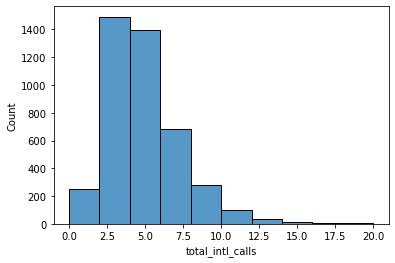

In [12]:
sns.histplot(raw_train['total_intl_calls'], bins=10)

Most of the customer made 2-6 calls in total in their whole subscription period.  
This explains the high 91% of customers making international calls without a plan.

### B. Data Wrangling

Ideas:
1. Encode binary features - international_plan, voice_mail_plan - DONE
2. Encode nominal features - area_code - DONE
3. Is it a good idea to encode 'state' feature? - has 51 unique values!
4. Bin feature values - account_length, number_vmail_messages, number_customer_service_calls (see if this would be beneficial as it already has less unique values)

#### 1. Encoding categorical features

In [13]:
# Converting Binary features
for dataset in raw_combined:
    dataset.international_plan.replace(['no', 'yes'], [0, 1], inplace=True)
    dataset.voice_mail_plan.replace(['no', 'yes'], [0, 1], inplace=True)

# Churn feature in train
raw_train.churn.replace(['no', 'yes'], [0, 1], inplace=True)

raw_train.head()
# raw_test.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
1,NJ,137,area_code_415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
2,OH,84,area_code_408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
3,OK,75,area_code_415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
4,MA,121,area_code_510,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0


In [14]:
# Converting Nominal feature
ohe = OneHotEncoder()
ohe.fit(raw_train[['area_code']])

# Train
encoded_values = ohe.transform(raw_train[['area_code']])
raw_train[ohe.categories_[0]] = encoded_values.toarray()
raw_train = raw_train.drop('area_code', axis=1)

# Test
encoded_values = ohe.transform(raw_test[['area_code']])
raw_test[ohe.categories_[0]] = encoded_values.toarray()
raw_test = raw_test.drop('area_code', axis=1)

raw_train.head()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,area_code_408,area_code_415,area_code_510
0,OH,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0.0,1.0,0.0
1,NJ,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0.0,1.0,0.0
2,OH,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,1.0,0.0,0.0
3,OK,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,0.0,1.0,0.0
4,MA,121,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0,0.0,0.0,1.0


In [15]:
raw_test.head()

,id,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,area_code_408,area_code_415,area_code_510
0,1,KS,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0.0,1.0,0.0
1,2,AL,118,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,0.0,0.0,1.0
2,3,IA,62,0,0,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4,0.0,1.0,0.0
3,4,VT,93,0,0,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3,0.0,0.0,1.0
4,5,NE,174,0,0,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3,0.0,1.0,0.0


#### 2. Creating new features

[107 137  84  75 121 147 117 141  65  74 168  95 161  85  76  73  77 130
 111 132  57  54  20  49  12  36  78 136  98 135  34 160  64  59 142  97
  52  60  10  96  81 125 174 116 149  38  40  43 113 126 150 138 162  90
  50  82 144  46  70 128  94 155  80  99 120 108 122  93 157  63  41 193
  61  92 163  91 127 110 103 145  56 151  83 139   6 115  62 185 148  32
  68  25 179  67  19 170 106  51 118 208 131  53 105  66  35  88 123  45
 100 215  22  33  86 114  24 119 101 146 143  48 167  89 199 166 158 196
 112 209  16  39 104 129  55  44  79 159 194  87  21 133 224 140  58 109
  71  72 124 102 165  18  30 190  47 152  26  69  31 186 171  28 153 172
 169  13 189 176 156  37  27 134 243  42  23   1 200   5 178 181 182 217
 164 177  11   9 173 154  29 180   3   2   7 232 192 195 197 225 191 201
  15  17 183 212 210 175   4 184 188 204 221 187  14 216 222   8 202]


<AxesSubplot:xlabel='account_length', ylabel='Count'>

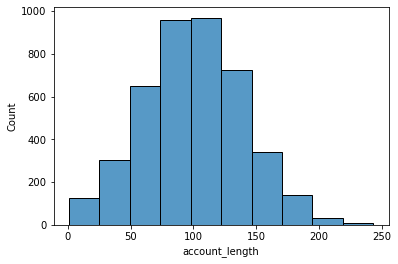

In [16]:
# account_length
print(raw_train['account_length'].unique())

sns.histplot(raw_train['account_length'], bins=10)
# Most of the customers had the service for between 50 to 150 months

In [17]:
# It might be worth to bin the account_length feature and create a new feature
# Check correlation of bins to churn value

# raw_train['account_length_bin'] = pd.cut(raw_train['account_length'], 8)
# raw_train[['account_length_bin', 'churn']].groupby('account_length_bin').sum().sort_values(by="churn", ascending=False)

# Not a very good correlation, but we can use this feature later to see if it helps. TODO

In [18]:
raw_train.head(10)

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,area_code_408,area_code_415,area_code_510
0,OH,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0.0,1.0,0.0
1,NJ,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0.0,1.0,0.0
2,OH,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,1.0,0.0,0.0
3,OK,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,0.0,1.0,0.0
4,MA,121,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0,0.0,0.0,1.0
5,MO,147,1,0,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,0,0.0,1.0,0.0
6,LA,117,0,0,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,0,1.0,0.0,0.0
7,WV,141,1,1,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,0,0.0,1.0,0.0
8,IN,65,0,0,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,1,0.0,1.0,0.0
9,RI,74,0,0,0,187.7,127,31.91,163.4,148,13.89,196.0,94,8.82,9.1,5,2.46,0,0,0.0,1.0,0.0


In [19]:
raw_train.shape

(4250, 22)

#### 3. Encode 'state' feature
We can use OneHotEncoder, but that would not be a good solution as this is a high cardinality feature (i.e. high number of unique values - 51).  
We can use other methods such as Hashing for encoding this feature.

In [20]:
# raw_train = raw_train.drop('state', axis=1)
ce_hashing = ce.HashingEncoder(cols='state')
raw_train = ce_hashing.fit_transform(raw_train)
print(raw_train.shape)
raw_train.head()

(4250, 29)


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,area_code_408,area_code_415,area_code_510
0,0,0,0,0,1,0,0,0,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0.0,1.0,0.0
1,0,1,0,0,0,0,0,0,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0.0,1.0,0.0
2,0,0,0,0,1,0,0,0,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,1.0,0.0,0.0
3,0,0,0,0,1,0,0,0,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,0.0,1.0,0.0
4,0,0,0,0,1,0,0,0,121,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0,0.0,0.0,1.0


In [21]:
raw_test = ce_hashing.transform(raw_test)
print(raw_test.shape)
raw_test.head()

(750, 29)


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,id,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,area_code_408,area_code_415,area_code_510
0,0,1,0,0,0,0,0,0,1,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0.0,1.0,0.0
1,0,1,0,0,0,0,0,0,2,118,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,0.0,0.0,1.0
2,0,0,0,0,0,0,0,1,3,62,0,0,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4,0.0,1.0,0.0
3,0,0,0,0,1,0,0,0,4,93,0,0,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3,0.0,0.0,1.0
4,1,0,0,0,0,0,0,0,5,174,0,0,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3,0.0,1.0,0.0


In [22]:
raw_train.dtypes

col_0                              int64
col_1                              int64
col_2                              int64
col_3                              int64
col_4                              int64
col_5                              int64
col_6                              int64
col_7                              int64
account_length                     int64
international_plan                 int64
voice_mail_plan                    int64
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_

#### 4. Data leakage
The idea of Data leakage doesn't apply to this notebook as we didn't perform any imputation tasks above.  
We only performed encoding which doesn't lead to data leakage (my understanding).

#### 5. Get Validation dataset

We are creating validation dataset so that we can evaluate model performance before submission.

In [23]:
# Divide dataset into independent and dependent features

# Moving the dependent column to the end
raw_train_cols = raw_train.columns.tolist()
print(raw_train_cols)
print(len(raw_train_cols))
raw_train_cols = raw_train_cols[:-4] + raw_train_cols[-3:] + raw_train_cols[-4:-3]
print(len(raw_train_cols))
print(raw_train_cols)

raw_train = raw_train[raw_train_cols]
raw_train.head()
raw_train.shape

# Divide datset
raw_train_X = raw_train.iloc[:, :-1]
raw_train_y = raw_train.iloc[:, -1]
raw_train_X.shape
raw_train_y.shape

['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'account_length', 'international_plan', 'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls', 'churn', 'area_code_408', 'area_code_415', 'area_code_510']
29
29
['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'account_length', 'international_plan', 'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls', 'area_code_408', 'area_code_415', 'area_code_510', 'chur

(4250,)

In [24]:
raw_train_y.head()

0    0
1    0
2    0
3    0
4    0
Name: churn, dtype: int64

In [25]:
X_train, X_val, y_train, y_val = train_test_split(raw_train_X, raw_train_y, test_size=0.3)

#### 6. Normalizing data

**Note:** We'll fit the normalizer on training data and then transform training, validation and test datasets.  
This is important to avoid data leakage.

In [26]:
X_train.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,area_code_408,area_code_415,area_code_510
3007,1,0,0,0,0,0,0,0,108,1,0,0,275.9,84,46.90,203.0,91,17.26,211.4,108,9.51,6.7,4,1.81,2,0.0,0.0,1.0
725,0,0,0,0,0,1,0,0,155,0,0,0,165.4,108,28.12,183.7,103,15.61,80.2,108,3.61,8.9,4,2.40,3,0.0,0.0,1.0
944,1,0,0,0,0,0,0,0,11,0,1,24,131.5,98,22.36,230.2,111,19.57,283.7,87,12.77,10.0,3,2.70,2,1.0,0.0,0.0
2099,0,1,0,0,0,0,0,0,83,0,1,38,107.9,90,18.34,140.4,94,11.93,253.6,79,11.41,10.5,2,2.84,0,1.0,0.0,0.0
2686,1,0,0,0,0,0,0,0,78,0,0,0,103.5,115,17.60,117.9,102,10.02,201.0,94,9.05,12.0,3,3.24,4,0.0,1.0,0.0


We only want to normalize data from indices 8 to -4, as the other column values are already between 0 an 1.  
But, even if we normalize all the columns including the ones which are already between 0 an 1, MinMaxScaler won't have an effect on them.  
(As MinMaxScaler scales values to be between 0 and 1)  

Taking the long approach below to only normalize specific columns, which is not required here, but doing it for practice.

In [27]:
# So let's first rearrange the columns (move all columns to be normalized at the end)

X_train_cols = X_train.columns.tolist()
print(len(X_train_cols))
X_train_cols = X_train_cols[:8] + X_train_cols[-3:] + X_train_cols[8:-3]
print(len(X_train_cols))

X_train = X_train[X_train_cols]
X_val = X_val[X_train_cols]

X_val.head()

28
28


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,area_code_408,area_code_415,area_code_510,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
2546,1,0,0,0,0,0,0,0,1.0,0.0,0.0,133,0,1,39,239.9,107,40.78,253.8,77,21.57,128.7,85,5.79,6.7,3,1.81,5
461,1,0,0,0,0,0,0,0,0.0,1.0,0.0,125,0,0,0,131.8,97,22.41,136.7,100,11.62,308.2,119,13.87,7.7,6,2.08,2
4144,1,0,0,0,0,0,0,0,0.0,1.0,0.0,136,0,0,0,121.5,80,20.66,220.1,97,18.71,179.5,94,8.08,10.4,5,2.81,1
453,0,0,0,0,0,0,0,1,0.0,0.0,1.0,69,1,0,0,279.8,90,47.57,248.7,91,21.14,171.0,118,7.69,8.4,10,2.27,2
185,0,0,0,1,0,0,0,0,0.0,1.0,0.0,65,0,0,0,213.4,111,36.28,234.5,94,19.93,250.1,123,11.25,2.7,4,0.73,1


In [28]:
# Normalizing features only from index 11 till the end

normalizer = MinMaxScaler()
normalizer.fit(X_train.iloc[:, 11:])

selected_cols_names = X_train.columns.tolist()[11:]
print(selected_cols_names)

print(X_train.shape)

X_train_norm_selected = pd.DataFrame(normalizer.transform(X_train.iloc[:, 11:]), columns=selected_cols_names)
X_val_norm_selected = pd.DataFrame(normalizer.transform(X_val.iloc[:, 11:]), columns=selected_cols_names)

# Joining normalized and left our columns
# We need to reset indexes, else if pandas is unable to match indexes, will result in NaN values 
X_train.reset_index(drop=True, inplace=True) 
X_train_norm_selected.reset_index(drop=True, inplace=True)

# Similar index reset for validation dataset
X_val.reset_index(drop=True, inplace=True) 
X_val_norm_selected.reset_index(drop=True, inplace=True)

X_train_norm = pd.concat([X_train.iloc[:, :11], X_train_norm_selected], axis=1)
X_val_norm = pd.concat([X_val.iloc[:, :11], X_val_norm_selected], axis=1)

['account_length', 'international_plan', 'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']
(2975, 28)


In [29]:
X_train_norm.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,area_code_408,area_code_415,area_code_510,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,0,0,0,0,0,0,0,0.0,0.0,1.0,0.442149,1.0,0.0,0.000000,0.784922,0.52500,0.784806,0.564987,0.538462,0.565160,0.535190,0.617143,0.535172,0.335,0.20,0.335185,0.222222
1,0,0,0,0,0,1,0,0,0.0,0.0,1.0,0.636364,0.0,0.0,0.000000,0.470555,0.67500,0.470549,0.511272,0.609467,0.511133,0.203038,0.617143,0.203151,0.445,0.20,0.444444,0.333333
2,1,0,0,0,0,0,0,0,1.0,0.0,0.0,0.041322,0.0,1.0,0.461538,0.374111,0.61250,0.374163,0.640690,0.656805,0.640799,0.718228,0.497143,0.718627,0.500,0.15,0.500000,0.222222
3,0,1,0,0,0,0,0,0,1.0,0.0,0.0,0.338843,0.0,1.0,0.730769,0.306970,0.56250,0.306894,0.390760,0.556213,0.390635,0.642025,0.451429,0.642093,0.525,0.10,0.525926,0.000000
4,1,0,0,0,0,0,0,0,0.0,1.0,0.0,0.318182,0.0,0.0,0.000000,0.294452,0.71875,0.294511,0.328138,0.603550,0.328094,0.508861,0.537143,0.509285,0.600,0.15,0.600000,0.444444


In [30]:
X_val_norm.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,area_code_408,area_code_415,area_code_510,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,0,0,0,0,0,0,0,1.0,0.0,0.0,0.545455,0.0,1.0,0.75,0.682504,0.66875,0.682396,0.706374,0.455621,0.706287,0.325823,0.485714,0.325830,0.335,0.15,0.335185,0.555556
1,1,0,0,0,0,0,0,0,0.0,1.0,0.0,0.512397,0.0,0.0,0.00,0.374964,0.60625,0.375000,0.380462,0.591716,0.380485,0.780253,0.680000,0.780529,0.385,0.30,0.385185,0.222222
2,1,0,0,0,0,0,0,0,0.0,1.0,0.0,0.557851,0.0,0.0,0.00,0.345661,0.50000,0.345716,0.612580,0.573964,0.612639,0.454430,0.537143,0.454699,0.520,0.25,0.520370,0.111111
3,0,0,0,0,0,0,0,1,0.0,0.0,1.0,0.280992,1.0,0.0,0.00,0.796017,0.56250,0.796017,0.692179,0.538462,0.692207,0.432911,0.674286,0.432752,0.420,0.50,0.420370,0.222222
4,0,0,0,1,0,0,0,0,0.0,1.0,0.0,0.264463,0.0,0.0,0.00,0.607112,0.69375,0.607095,0.652658,0.556213,0.652587,0.633165,0.702857,0.633089,0.135,0.20,0.135185,0.111111


In [31]:
# Normalize test data

# Remove 'id' column, but before that save 'id' feature for submission
raw_test_ids = raw_test['id']
raw_test = raw_test.drop('id', axis=1)

In [32]:
# Similar re-arranging of columns for test data.
# We can re-use the order of training columns as it's same as test
raw_test = raw_test[X_train_cols]
print(raw_test.shape)
raw_test.head()

(750, 28)


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,area_code_408,area_code_415,area_code_510,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,0,1,0,0,0,0,0,0,0.0,1.0,0.0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,0,1,0,0,0,0,0,0,0.0,0.0,1.0,118,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,0,0,0,0,0,0,0,1,0.0,1.0,0.0,62,0,0,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,0,0,0,0,1,0,0,0,0.0,0.0,1.0,93,0,0,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,1,0,0,0,0,0,0,0,0.0,1.0,0.0,174,0,0,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


In [33]:
raw_test_norm_selected = pd.DataFrame(normalizer.transform(raw_test.iloc[:, 11:]), columns=selected_cols_names)

# Concat all test data columns
# Reset indexes
raw_test.reset_index(drop=True, inplace=True) 
raw_test_norm_selected.reset_index(drop=True, inplace=True)

raw_test_norm = pd.concat([raw_test.iloc[:, :11], raw_test_norm_selected], axis=1)
raw_test_norm.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,area_code_408,area_code_415,area_code_510,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,0,1,0,0,0,0,0,0,0.0,1.0,0.0,0.524793,0.0,1.0,0.480769,0.754196,0.6875,0.754183,0.549402,0.585799,0.549443,0.619494,0.520000,0.619584,0.500,0.15,0.500000,0.111111
1,0,1,0,0,0,0,0,0,0.0,0.0,1.0,0.483471,1.0,0.0,0.000000,0.635562,0.6125,0.635542,0.613972,0.597633,0.613949,0.516203,0.674286,0.516601,0.315,0.30,0.314815,0.000000
2,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.252066,0.0,0.0,0.000000,0.343385,0.4375,0.343373,0.854996,0.449704,0.854944,0.513924,0.565714,0.514350,0.655,0.30,0.655556,0.444444
3,0,0,0,0,1,0,0,0,0.0,0.0,1.0,0.380165,0.0,0.0,0.000000,0.542532,0.7125,0.542503,0.607292,0.656805,0.607400,0.328101,0.691429,0.328081,0.405,0.15,0.405556,0.333333
4,1,0,0,0,0,0,0,0,0.0,1.0,0.0,0.714876,0.0,0.0,0.000000,0.353627,0.4750,0.353581,0.771222,0.662722,0.771120,0.634684,0.657143,0.634778,0.775,0.25,0.775926,0.333333


Training, Validation, Test - All datasets have been normalized!

### C. Data Modeling

In [34]:
model_lr = LogisticRegression(solver='liblinear')
model_lr.fit(X_train_norm, y_train)
y_pred = model_lr.predict(X_val_norm)

# Accuracy
lr_accuracy = accuracy_score(y_val, y_pred)
lr_f1_score = f1_score(y_val, y_pred)
print('LogisticRegression - accuracy score: {} and f1_score: {}'.format(lr_accuracy, lr_f1_score))

pd.DataFrame(y_pred)[0].head(20)

LogisticRegression - accuracy score: 0.8698039215686274 and f1_score: 0.18627450980392157


0     0
1     0
2     0
3     1
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
Name: 0, dtype: int64

In [35]:
pd.DataFrame(y_val).head(20)

,churn
2546,0
461,0
4144,0
453,1
185,0
1315,0
3472,0
1862,0
1817,0
4212,0


In [36]:
model_svc = SVC()
model_svc.fit(X_train_norm, y_train)
y_pred = model_lr.predict(X_val_norm)

# Accuracy
svc_accuracy = accuracy_score(y_val, y_pred)
svc_f1_score = f1_score(y_val, y_pred)
print('SupportVector - accuracy score: {} and f1_score: {}'.format(svc_accuracy, svc_f1_score))

SupportVector - accuracy score: 0.8698039215686274 and f1_score: 0.18627450980392157


In [37]:
model_rfc = RandomForestClassifier()
model_rfc.fit(X_train_norm, y_train)
y_pred = model_rfc.predict(X_val_norm)

# Accuracy
rfc_accuracy = accuracy_score(y_val, y_pred)
rfc_f1_score = f1_score(y_val, y_pred)
print('RandomForestClassifier - accuracy score: {} and f1_score: {}'.format(rfc_accuracy, rfc_f1_score))

RandomForestClassifier - accuracy score: 0.96 and f1_score: 0.8294314381270904


For now, RandomForestClassifier seems to be performing the best.

### D. Submission

In [38]:
# Predict on Test data using RandomForestClassifier
test_pred = model_rfc.predict(raw_test_norm)

# Check frequency of output values
elements, count = np.unique(test_pred, return_counts=True)
(elements, count)

(array([0, 1], dtype=int64), array([670,  80], dtype=int64))

In [39]:
# Submission features
submission_df = pd.DataFrame({'id': raw_test_ids, 'churn': test_pred})

# As required, replace predicted values by 'yes'/'no'
submission_df['churn'].replace((0, 1), ('no', 'yes'), inplace=True)

print(submission_df.shape)
submission_df.head()

(750, 2)


,id,churn
0,1,no
1,2,no
2,3,yes
3,4,no
4,5,no


In [40]:
# Create submission file
submission_df.to_csv('submission.csv', index=False)

Here we've used classic algorithms without hyperparameter tuning and without ensemble or boosting algorithms.
Next steps:
1. Hyperparamter tuning
2. Apply Ensmble techniques
3. Boosting